<a href="https://colab.research.google.com/github/sanda-avram/Transformers-on-ROST/blob/main/TkCl/ROST_TkCl_xlm_roberta_english.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install datasets

In [13]:
from datasets import Dataset
import pandas as pd
train_df=messages = pd.read_csv('trainSet1.csv', sep=',', names=["label", "text"])
test_df=messages = pd.read_csv('testSet1.csv', sep=',', names=["label", "text"])


train_ds = Dataset.from_pandas(train_df, split="train")
test_ds = Dataset.from_pandas(test_df, split="test")

model_name = "xlm-roberta-large-finetuned-conll03-english"

In [ ]:
!pip install transformers

In [14]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained(model_name)

In [15]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=256)

train_dataset = train_ds.map(tokenize_function, batched=True)
test_dataset = test_ds.map(tokenize_function, batched=True)

  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

In [16]:
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=10)

Some weights of the model checkpoint at xlm-roberta-large-finetuned-conll03-english were not used when initializing XLMRobertaForSequenceClassification: ['classifier.weight', 'classifier.bias', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-large-finetuned-conll03-english and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.de

In [ ]:
!pip install evaluate


In [18]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(output_dir="testTrainer", evaluation_strategy="epoch")

In [19]:
import numpy as np
import evaluate

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

In [20]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `XLMRobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `XLMRobertaForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 5411
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2031
  Number of trainable parameters = 559900682


Epoch,Training Loss,Validation Loss,Accuracy
1,2.118900,2.160460,0.215341
2,2.078500,2.151168,0.215341
3,2.081300,2.137104,0.215341


Saving model checkpoint to testTrainer/checkpoint-500
Configuration saved in testTrainer/checkpoint-500/config.json
Model weights saved in testTrainer/checkpoint-500/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `XLMRobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `XLMRobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1421
  Batch size = 8
Saving model checkpoint to testTrainer/checkpoint-1000
Configuration saved in testTrainer/checkpoint-1000/config.json
Model weights saved in testTrainer/checkpoint-1000/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `XLMRobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `XLMRobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evalu

TrainOutput(global_step=2031, training_loss=2.090070975231807, metrics={'train_runtime': 783.137, 'train_samples_per_second': 20.728, 'train_steps_per_second': 2.593, 'total_flos': 7564225368333312.0, 'train_loss': 2.090070975231807, 'epoch': 3.0})

In [21]:
trainer.evaluate(trainer.eval_dataset)

The following columns in the evaluation set don't have a corresponding argument in `XLMRobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `XLMRobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1421
  Batch size = 8


{'eval_loss': 2.137104034423828,
 'eval_accuracy': 0.21534130893736805,
 'eval_runtime': 16.9652,
 'eval_samples_per_second': 83.76,
 'eval_steps_per_second': 10.492,
 'epoch': 3.0}

In [22]:
predicted=trainer.predict(test_dataset)

The following columns in the test set don't have a corresponding argument in `XLMRobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `XLMRobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 1421
  Batch size = 8


In [23]:
c=0
y=[]
for v in predicted.predictions:
  c+=1

  max = v[0]
  index = 0
  for i in range(1,len(v)):
    if v[i] > max:
      max = v[i]
      index = i
  y.append(index)

In [24]:
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
cm=confusion_matrix(test_dataset['label'], y)
print(cm)
accuracy = accuracy_score(test_dataset['label'], y)
print("accuracy:", accuracy)
# Calculate macro-accuracy
#macro_accuracy = np.mean(np.diag(cm))

#print("Macro-accuracy:", macro_accuracy/10)
from sklearn.metrics import classification_report

print(classification_report(test_dataset['label'], y, digits=3))

[[  0   0   0   0   0   0   0   0   0  74]
 [  0   0   0   0   0   0   0   0   0 216]
 [  0   0   0   0   0   0   0   0   0 242]
 [  0   0   0   0   0   0   0   0   0  86]
 [  0   0   0   0   0   0   0   0   0  34]
 [  0   0   0   0   0   0   0   0   0 185]
 [  0   0   0   0   0   0   0   0   0  25]
 [  0   0   0   0   0   0   0   0   0  77]
 [  0   0   0   0   0   0   0   0   0 176]
 [  0   0   0   0   0   0   0   0   0 306]]
accuracy: 0.21534130893736805
              precision    recall  f1-score   support

           0      0.000     0.000     0.000        74
           1      0.000     0.000     0.000       216
           2      0.000     0.000     0.000       242
           3      0.000     0.000     0.000        86
           4      0.000     0.000     0.000        34
           5      0.000     0.000     0.000       185
           6      0.000     0.000     0.000        25
           7      0.000     0.000     0.000        77
           8      0.000     0.000     0.000       17

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [25]:
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(test_dataset['label'], y)

0.1

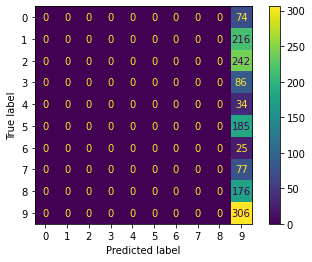

In [26]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
 

In [ ]:
!kill 7123
%reload_ext tensorboard
%tensorboard --logdir ./testTrainer/
